In [4]:
%matplotlib inline
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from plantcv import plantcv as pcv
from PIL import Image

In [5]:
# Set variables
pcv.params.debug = 'plot'
pcv.params.debug_outdir = '../images/results'
img_file = '../images/2.jpg'

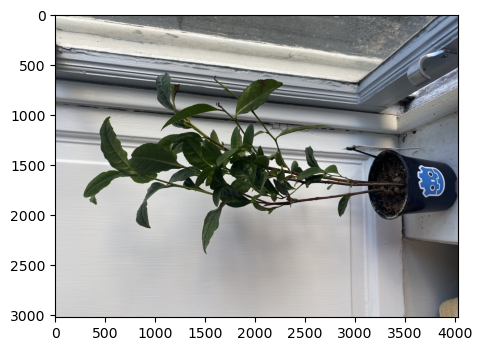

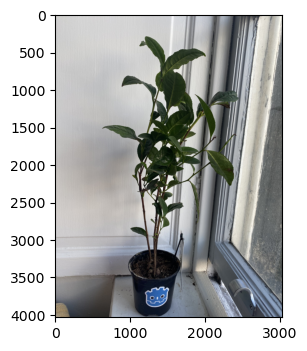

In [6]:
# Read image
img, path, filename = pcv.readimage(filename=img_file)

# For some reason, some images need to be rotated
img = np.array(Image.fromarray(img).transpose(Image.ROTATE_270))
pcv.plot_image(img)

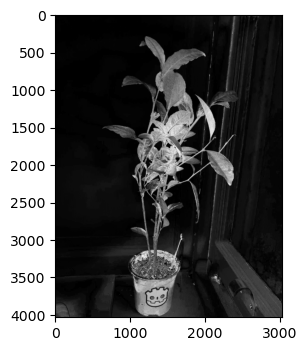

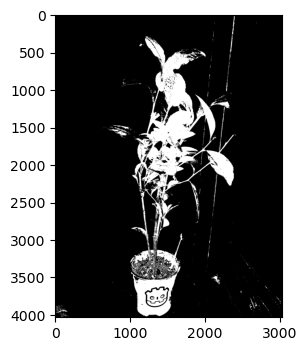

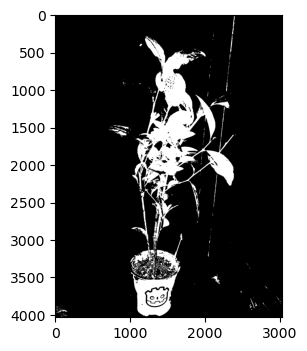

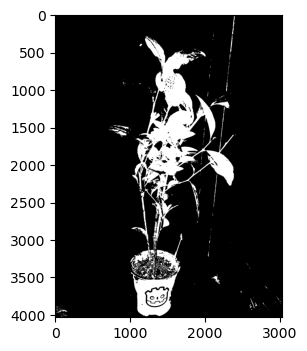

In [7]:
# Convert RGB to HSV and extract the saturation channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')

# Threshold the saturation image
s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')

# Median Blur
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)

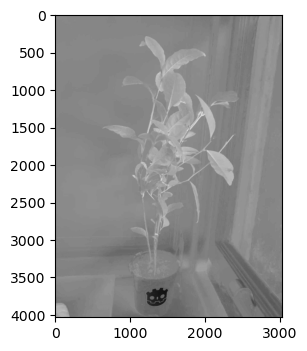

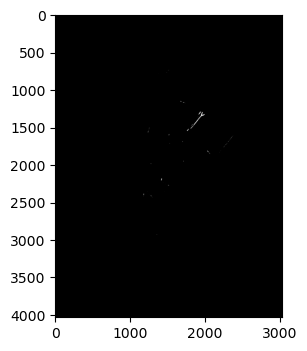

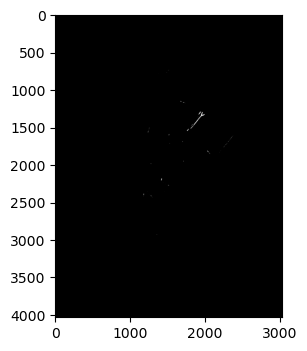

In [8]:
# Convert RGB to LAB and extract the Blue channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
b_cnt = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')

# Fill small objects
# b_fill = pcv.fill(b_thresh, 10)

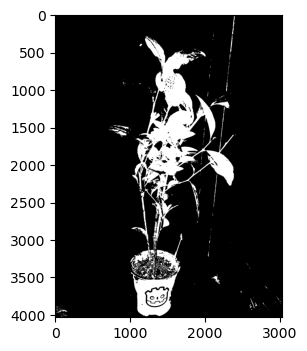

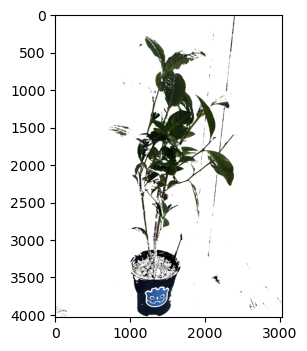

In [9]:
# Join the thresholded saturation and blue-yellow images
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)

# Apply Mask (for VIS images, mask_color=white)
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')

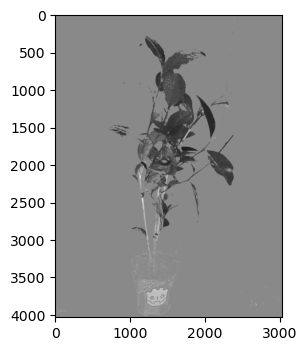

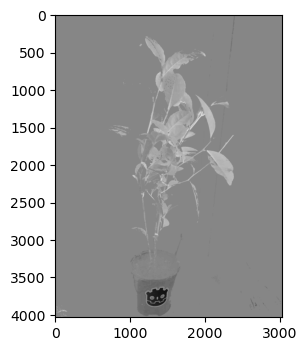

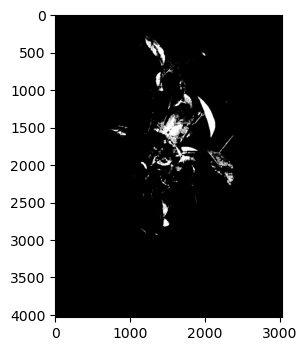

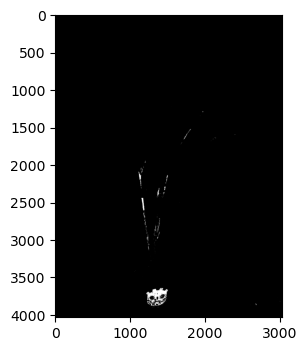

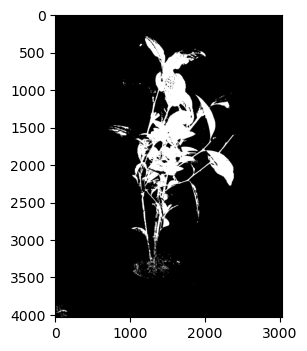

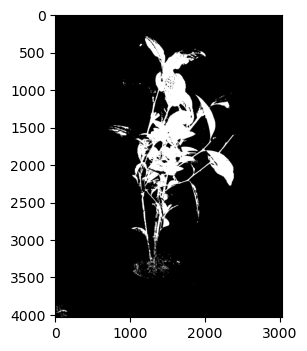

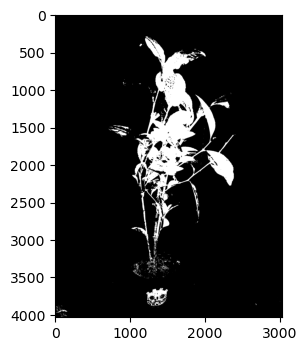

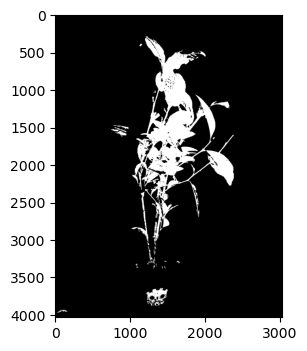

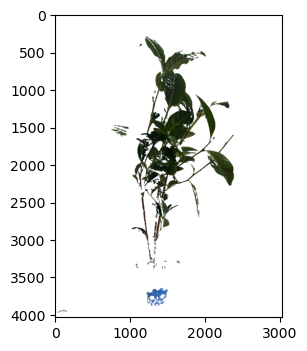

In [10]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')

# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, max_value=255, object_type='light')

# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)

# Fill small objects
ab_fill = pcv.fill(bin_img=ab, size=200)

# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')

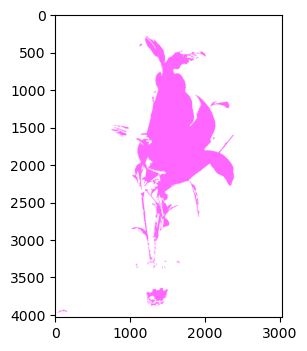

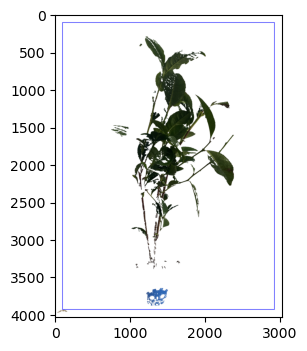

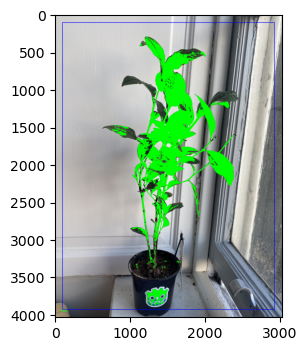

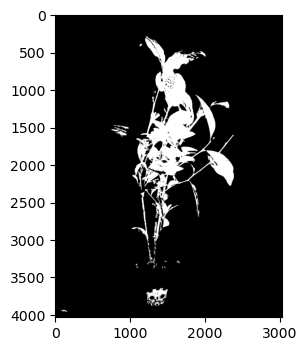

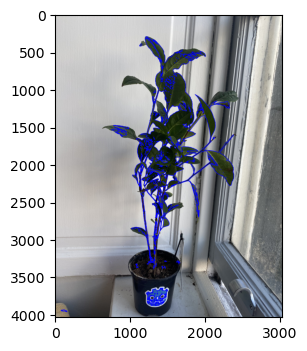

In [11]:
# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(img=masked2, mask=ab_fill)

# Define ROI
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=100, y=100, h=img.shape[0]-200, w=img.shape[1]-200)

# Decide which objects to keep
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                           roi_hierarchy=roi_hierarchy, 
                                                           object_contour=id_objects, 
                                                           obj_hierarchy=obj_hierarchy,
                                                           roi_type='partial')

# Object combine kept objects
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)

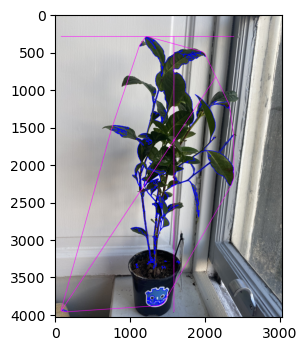

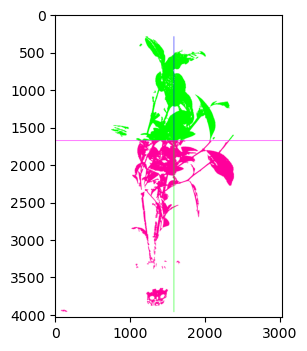

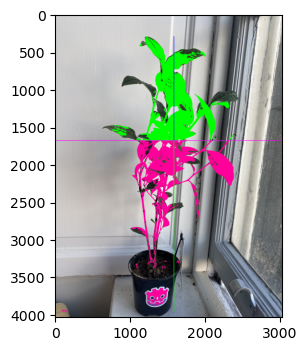

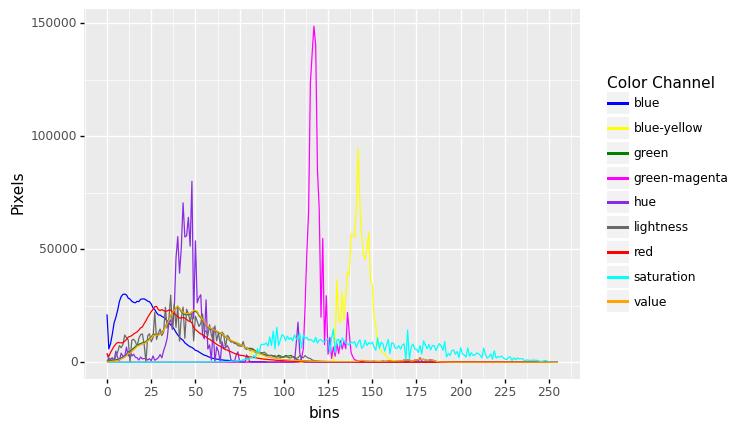

<ggplot: (110378512159)>


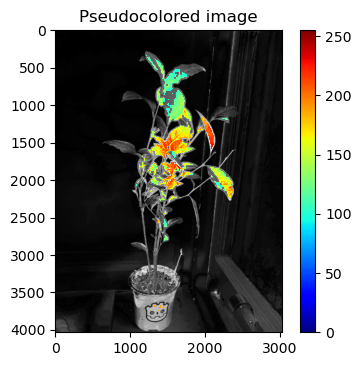

In [12]:
############### Analysis ################

outfile = os.path.join('../images/results', filename)

# Find shape properties, output shape image (optional)
shape_imgs = pcv.analyze_object(img=img, obj=obj, mask=mask, label="default")

# Shape properties relative to user boundary line (optional)
boundary_img1 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, line_position=1680, label="default")

# Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)
color_histogram = pcv.analyze_color(rgb_img=img, mask=mask, hist_plot_type='all', label="default")

# Pseudocolor the grayscale image
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=s, mask=mask, cmap='jet')

# Write shape and color data to results file
pcv.print_results(filename='results.json')

In [13]:
x, y = pcv.outputs.observations['default']['center_of_mass']['value']
width = pcv.outputs.observations['default']['width']['value']
height = pcv.outputs.observations['default']['height']['value']

In [14]:
pcv.outputs.observations['default']['center_of_mass']['value']

(1584.6005205320455, 1671.5314661994175)

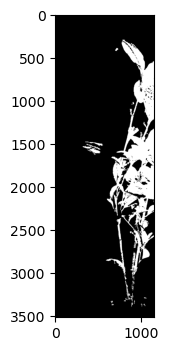

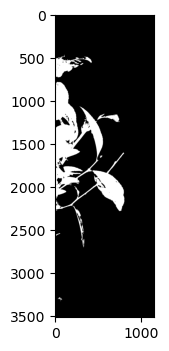

578477 462968
Left Percentage: 55.545612106256215% Right Percentage: 44.454387893743785%


In [16]:
x = int(x)
y = int(y)

top = max(int(y - (height / 2)), 0)
bottom = min(int(y + (height / 2)), img.shape[0])

left = max(int(x - (width / 2)), 0)
right = min(int(x + (width / 2)), img.shape[1])

left_half = mask[top:bottom, left:x]
right_half = mask[top:bottom, x:right]
pcv.plot_image(left_half)
pcv.plot_image(right_half)

left_half_count = cv2.countNonZero(left_half)
right_half_count = cv2.countNonZero(right_half)

print(left_half_count, right_half_count)
left_percent = (left_half_count / (left_half_count + right_half_count))
print(f'Left Percentage: {left_percent * 100}% Right Percentage: {(1 - left_percent) * 100}%')